In [2]:
!pip install kaggle

In [3]:
!pip install sklearn

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
from sklearn import model_selection
import skimage

In [6]:
from PIL import Image

In [7]:
import cv2 as cv

In [8]:
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv1D,Conv2D, MaxPool1D,MaxPooling2D,ZeroPadding1D,ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten,Dense
from keras.layers import BatchNormalization
from keras.optimizers import Adam,RMSprop,SGD
from keras import regularizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn import preprocessing
from tensorflow.keras.applications import VGG16,VGG19


In [11]:
# how to convert pandas data frame to numpy array

import pandas as pd
import numpy as np

def getPandaDataFrame(name):
  data = pd.read_csv(name)
  return data
test_data = getPandaDataFrame('test_data.csv')
train_data = getPandaDataFrame('train_data.csv')
train_target = getPandaDataFrame('train_target.csv')


In [12]:
train_data_np_array = train_data.to_numpy()
test_images = test_data.to_numpy()
train_reaction = train_target.to_numpy()
category_encoder = preprocessing.OneHotEncoder() 
train_reaction_1hot = category_encoder.fit_transform(train_reaction)

In [13]:
test_images.shape

(3964, 2304)

Scaling the data

In [14]:
scaler = preprocessing.StandardScaler().fit(train_data_np_array)
standard_train_data = scaler.transform(train_data_np_array)
standard_test_data = scaler.transform(test_images)

In [15]:
def arr2Img(numpy_matrix):
  image_array = []
  i = 0
  for i in range(numpy_matrix.shape[0]):
    image_array.append(numpy_matrix[i].reshape(48,48))
  return np.asarray(image_array,dtype='uint8')  

non standardized

In [16]:
np_train_img_full=arr2Img(train_data_np_array)
np_test_img_full = arr2Img(test_images)
print(np_train_img_full.shape)
print(np_test_img_full.shape)

(16174, 48, 48)
(3964, 48, 48)


Standardized

In [14]:
np_train_img_full=arr2Img(standard_train_data)
np_test_img_full = arr2Img(standard_test_data)
print(np_train_img_full.shape)
print(np_test_img_full.shape)

(16174, 48, 48)
(3964, 48, 48)


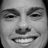

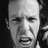

In [17]:
img = Image.fromarray(np_train_img_full[0])
img2 = Image.fromarray(np_test_img_full[0])
display(img)
display(img2)

In [18]:
def grey2RGB(numpy_array):
  return np.stack((numpy_array,)*3,axis=-1) 


In [19]:
np_train_img_full_3 = grey2RGB(np_train_img_full)
np_test_img_full_3 = grey2RGB(np_test_img_full)


In [20]:
X_training_set,X_testing_set,Y_training_set,Y_testing_set = model_selection.train_test_split(np_train_img_full_3,train_reaction_1hot.toarray(),test_size=0.30,random_state=0)

In [21]:
print(X_training_set.shape)
print(X_testing_set.shape)
print(Y_training_set.shape)
print(Y_testing_set.shape)

(11321, 48, 48, 3)
(4853, 48, 48, 3)
(11321, 3)
(4853, 3)


Data augmentation

In [22]:
b_size = 32
train_data_gen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

test_data_gen = ImageDataGenerator(rescale=1/255)

train_generator = train_data_gen.flow(X_training_set,
                                      Y_training_set,
                                      batch_size=b_size,)

validation_generator = test_data_gen.flow(X_testing_set,Y_testing_set,batch_size=b_size)



Custom model

In [38]:
model = Sequential()
#model.add(Conv2D(32,(3,3),input_shape=X_training_set.shape[1:],activation='relu',kernel_regularizer=regularizers.l2(.001)))
#model.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer=regularizers.l2(.001)))

model.add(Conv2D(32,(3,3),input_shape=X_training_set.shape[1:],activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))

#model.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(.001)))
#model.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(.001)))


model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(BatchNormalization())

#model.add(Conv2D(128,(3,3),activation='relu'))
#model.add(Conv2D(128,(3,3),activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))

model.add(Dense(3,activation='softmax'))


In [ ]:
model = Sequential()
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape = (48,48,3))
conv_base.trainable = False
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [24]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
best_model_file_name = "custom_cnn.h5"
best_model = ModelCheckpoint(best_model_file_name,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1
                        )

In [56]:
history = model.fit(
    train_generator,
    steps_per_epoch=2000//b_size,
    epochs=50,
    validation_data = validation_generator,
    validation_steps=800/b_size,
    callbacks=[
               EarlyStopping(patience=1,restore_best_weights=True)
               #ReduceLROnPlateau(patience=4)
    ]
    )

Epoch 1/50
62/62 [==============================] - 2s 27ms/step - loss: 0.7012 - accuracy: 0.6920 - val_loss: 0.5681 - val_accuracy: 0.7625
Epoch 2/50
62/62 [==============================] - 2s 28ms/step - loss: 0.6695 - accuracy: 0.7061 - val_loss: 0.5817 - val_accuracy: 0.7450


In [222]:
model.save_weights('first_try.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'train' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


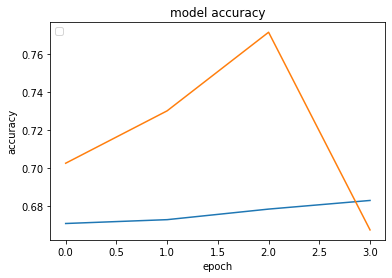

In [47]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],'validation',loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'train' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


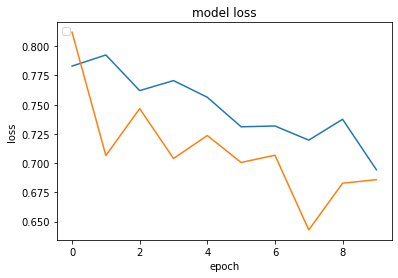

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],'validation',loc='upper left')
plt.show()

In [57]:
np_test_img_full_3.shape

(3964, 48, 48, 3)

In [58]:
# making predictions
print('predicitions for 1')
predictions = model.predict_classes(np_test_img_full_3)
print(predictions.shape)



predicitions for 1
(3964,)


In [54]:
pdf = pd.DataFrame(predictions)
pdf.to_csv("test.csv")
result = pd.read_csv("test.csv", names=["Id", "Category"])
result.to_csv("results.csv")

In [ ]:
list_of_pred_values = []
for x in range(predictions.shape[0]):
  list_of_pred_values.append(np.argmax(predictions[x]))
print(list_of_pred_values)
print(len(list_of_pred_values))

[0, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 0, 1, 0, 0, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 2, 2, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 2, 2, 0, 2, 0, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 

In [ ]:
print(range(predictions.shape[0]))
list_of_pred_index = list(range(predictions.shape[0]))
print(list_of_pred_index)
print(len(list_of_pred_index))

range(0, 3964)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

In [ ]:
# saving the csv file

info_dict = {
    'Id':list_of_pred_index,
    'Category':list_of_pred_values
}
submisson_data = pd.DataFrame(info_dict,columns=['Id','Category'])
submisson_data.to_csv('submission_data.csv',index=False)

In [ ]:
print(submisson_data)

        Id  Category
0        0         0
1        1         1
2        2         1
3        3         1
4        4         0
...    ...       ...
3960  3960         0
3961  3961         1
3962  3962         0
3963  3963         0
3964  3964         1

[3965 rows x 2 columns]
